In [372]:
!pip3 install pandas
!pip3 install numpy
!pip3 install sqlalchemy
!pip3 install nltk
!pip3 install gensim
!pip3 install torch
!pip3 install sklearn

In [414]:
import pandas as pd

import numpy as np
from numpy import save, load

from scipy.cluster.vq import kmeans, vq

import re
import os

from sqlalchemy import create_engine

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

from gensim import utils
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing  import preprocess_string

from string import punctuation

In [415]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/manan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [416]:
DATABASES = {
    'augur' : {
        'NAME'     : 'augur',
        'USER'     : 'manan',
        'PASSWORD' : 'mypass',
        'HOST'     : 'localhost',
        'PORT'     : 5432
    },
}

engine_string = "postgresql+psycopg2://{0}:{1}@{2}:{3}/{4}".format(
    DATABASES["augur"]["USER"],
    DATABASES["augur"]["PASSWORD"],
    DATABASES["augur"]["HOST"],
    DATABASES["augur"]["PORT"],
    DATABASES["augur"]["NAME"],
)

engine = create_engine(engine_string)

In [417]:
df_commits = pd.read_sql_table('commits',engine,schema='augur_data')
df_message = pd.read_sql_table('message',engine,schema='augur_data')
df_issues = pd.read_sql_table('issues',engine,schema='augur_data')
df_issue_message_ref = pd.read_sql_table('issue_message_ref',engine,schema='augur_data')
df_issue_events = pd.read_sql_table('issue_events',engine,schema='augur_data')
df_issue_labels = pd.read_sql_table('issue_labels',engine,schema='augur_data')

In [418]:
df_message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967 entries, 0 to 2966
Data columns (total 12 columns):
msg_id                  2967 non-null int64
rgls_id                 0 non-null object
msg_text                2967 non-null object
msg_timestamp           2967 non-null datetime64[ns]
msg_sender_email        0 non-null object
msg_header              0 non-null object
pltfrm_id               2967 non-null int64
tool_source             2967 non-null object
tool_version            2967 non-null object
data_source             2967 non-null object
data_collection_date    584 non-null datetime64[ns]
cntrb_id                2967 non-null int64
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 278.3+ KB


### Remove Columns which have very few entries or are not useful

In [419]:
df_message_cleaned = df_message.drop(["msg_id", "rgls_id", "msg_sender_email", "msg_header", "data_collection_date"], axis=1)

### Drop Columns in which the number of unique values is less than 40%

In [420]:
for i in df_message_cleaned.columns:
    if df_message_cleaned[i].unique().shape[0] <= 0.4 * len(df_message_cleaned):
        df_message_cleaned = df_message_cleaned.drop(i, axis=1)

In [421]:
df_message_cleaned

,msg_text,msg_timestamp
0,That was quick.,2019-10-18 18:53:05
1,Thanks for opening this pull request! 🚀\nWe're...,2019-10-15 23:34:53
2,Congrats on merging your first pull request! 🎉...,2019-10-16 15:39:15
3,@gabe-heim : I confirmed that this is an issue...,2019-10-14 14:21:38
4,@Nebrethar : Can you let @gabe-heim and @micha...,2019-10-14 14:15:36
...,...,...
2962,"Note, I created the pr #14 based on the table ...",2019-05-30 16:02:07
2963,This was done in the release,2019-08-08 15:28:24
2964,done,2019-04-19 11:51:31
2965,"I also can't seem to assign issues, so pinging...",2019-04-19 07:18:59


# Preprocess Data
Remove punctuations, links, usernames, numbers and finding the root of each word by removing the morphology using a stemmer

In [903]:
punc = list(punctuation)
punc.remove('@')
stopwords = nltk.corpus.stopwords.words('english')

In [904]:
def clean_text(text, punc, stopwords):
    paragraph = [word.strip().lower() for word in text.split(" ") if not word.startswith('@') and word not in punc]
    paragraph = " ".join([word for word in paragraph if not word.startswith("https") and word not in stopwords])
    
    paragraph = "".join([word for word in paragraph if word not in punc])
    paragraph = re.sub('[0-9]+', '', paragraph)
    paragraph = re.split("\W+", paragraph)
    ps = nltk.PorterStemmer()
    paragraph = [ps.stem(word) for word in paragraph]
    return " ".join(paragraph).strip()

In [905]:
df_message_cleaned['msg_text'] = df_message_cleaned['msg_text'].map(lambda x : clean_text(x, punc, stopwords))
X = df_message_cleaned['msg_text'].values

# Prepare a Corpus of Words for Doc2Vec

In [906]:
def prepare_corpus():
    for idx, val in enumerate(X):
        tokens = utils.simple_preprocess(val)
        yield TaggedDocument(tokens, [idx])

In [907]:
X_corpus = list(prepare_corpus())

In [908]:
class DocVectorizer():
    def __init__(self, epochs, corpus, vector_size):
        self.epochs = epochs
        self.vector_size = vector_size
        self.corpus = corpus
        
    def train(self):
        model = Doc2Vec(vector_size=self.vector_size, epochs=self.epochs)
        
        model.build_vocab(self.corpus)
        
        for epoch in range(self.epochs):
            model.train(
                self.corpus,
                total_examples=model.corpus_count, 
                epochs=1
            )
            model.alpha -= 0.01
            model.min_alpha = model.alpha
        
        self.model = model
        
    def predict(self, inp):
        tokens = utils.simple_preprocess(inp)
        
        return self.model.infer_vector(tokens)

# Train Doc2Vec

In [909]:
model = DocVectorizer(20, X_corpus, 200)
model.train()

In [910]:
doc2vec = []
for inp in X:
    doc2vec.append(model.predict(inp))
    
doc2vec = np.array(doc2vec)

# Analysis of Vectors obtained by Doc2Vec

Reduce dimensions of the vector obtained by Doc2Vec to 2 using a $cosine$ kernel for PCA.

In [941]:
pca = KernelPCA(n_components=2, kernel='cosine')
vecs = pca.fit_transform(doc2vec)

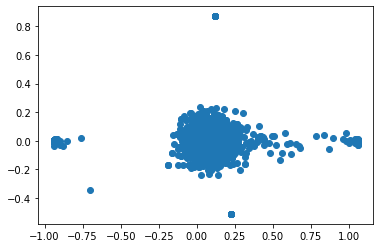

In [942]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(vecs[:, 0], vecs[:, 1])

As we can see in the plot above, most data points are concentrated towards the centre. The anomalies are the very clear outliers that can be seen in the plot above. In order to find the anomalies, we perform KMeans clustering to split the data into 2 clusters of which one will be the set of outliers

In [943]:
centroids, avg_distance = kmeans(vecs, 1)

In [944]:
labels, distances = vq(vecs, centroids)

The following plot is according to the labels obtained after KMeans clustering

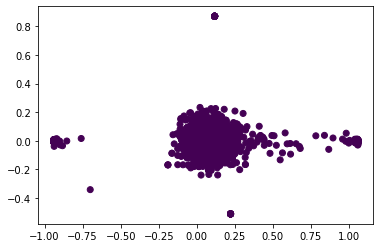

In [945]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(vecs[:, 0], vecs[:, 1],c=labels)

We add a cutoff to the distance for each data point from the nearest centroid and make each entry an anomaly if it's distance from the closest centroid is greater than the cutoff.

In [960]:
anomalies_idx = []
anomaly_label = []

for idx, val in enumerate(distances):
    if val > 0.7:
        anomalies_idx.append(idx)
        anomaly_label.append(1)
    else:
        anomaly_label.append(0)


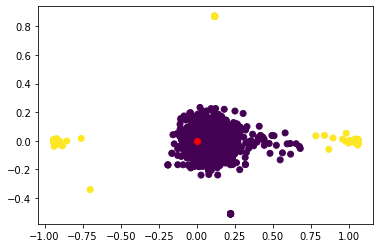

In [961]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(vecs[:, 0], vecs[:, 1],c=anomaly_label)
ax.scatter(centroids[:, 0], centroids[:, 1], c='r')

# Anomolous Messages

In [957]:
df_message['isAnAnomaly'] = pd.Series(anomaly_label)
df_message[df_message['isAnAnomaly'] == 1]

,msg_id,rgls_id,msg_text,msg_timestamp,msg_sender_email,msg_header,pltfrm_id,tool_source,tool_version,data_source,data_collection_date,cntrb_id,isAnAnomaly
0,1691707,None,That was quick.,2019-10-18 18:53:05,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277117,1
1,1691708,None,Thanks for opening this pull request! 🚀\nWe're...,2019-10-15 23:34:53,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277138,1
8,1691715,None,That's a good idea,2019-10-15 17:48:32,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277118,1
12,1691719,None,We took notes as @andyl @vinodkahuja and @Geor...,2019-10-11 22:30:52,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277126,1
13,1691720,None,"I will watch the video ASAP, but in the meanti...",2019-10-11 23:46:51,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277112,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,1694653,None,@klumb Requesting your OK,2019-07-29 18:45:10,None,None,25150,GitHub Pull Request Worker,0.0.1,GitHub API,2019-10-21 00:17:24,277117,1
2947,1694654,None,This is fine,2019-07-29 19:04:39,None,None,25150,GitHub Pull Request Worker,0.0.1,GitHub API,2019-10-21 00:17:24,277148,1
2961,1694668,None,Issue #6 is related,2019-04-23 23:58:53,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277126,1
2964,1694671,None,done,2019-04-19 11:51:31,None,None,25150,GitHub API Worker,0.0.3,GitHub API,NaT,277126,1


# Anomaly Detection Using Isolation Forest

In [962]:
from sklearn.ensemble import IsolationForest

In [968]:
isolation_forest = IsolationForest(n_estimators=1000)
labels = isolation_forest.fit_predict(vecs)

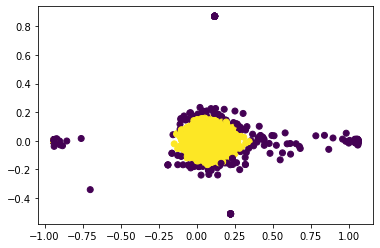

In [969]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(vecs[:, 0], vecs[:, 1],c=labels)

In [ ]:
df_message_cleaned["isAnomaly"] = pd.Series(labels)
df_message_cleaned[]